In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import joblib

In [3]:
df = joblib.load('../data/processed/data_1003.jblb')['df']
df['x_diff'] = df['receiver_x'] - df['thrower_x']
df['y_diff'] = df['receiver_y'] - df['thrower_y']
df['throw_angle'] = np.arctan2(df['y_diff'], df['x_diff'])
df['throw_distance'] = np.sqrt(df['x_diff']**2 + df['y_diff']**2)

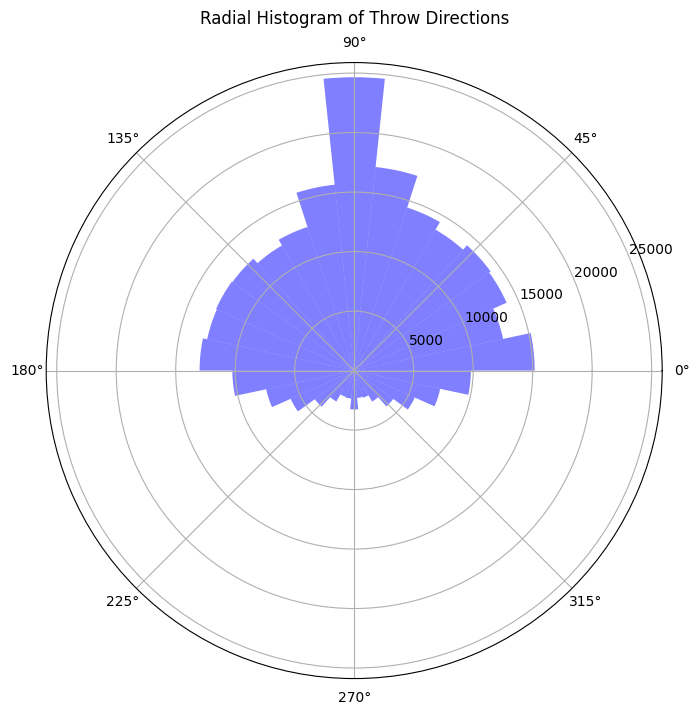

In [4]:
## Plot Radial Histogram of Directions
num_bins_angle = 30

angle_bins = np.linspace(-np.pi, np.pi, num_bins_angle + 1)
hist, _ = np.histogram(df['throw_angle'], bins=angle_bins)
bin_width = angle_bins[1] - angle_bins[0]
theta = angle_bins[:-1] + bin_width / 2

# Create a figure
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(theta, hist, width=bin_width, bottom=0.0, color='b', alpha=0.5, edgecolor='none')
ax.set_title('Radial Histogram of Throw Directions', va='bottom')
plt.show()


/var/folders/r4/cqt7s71n4k18qp94swd6_njr0000gn/T/ipykernel_99758/727237445.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c = ax.pcolormesh(theta, r, colors.T, cmap='viridis', shading='auto')


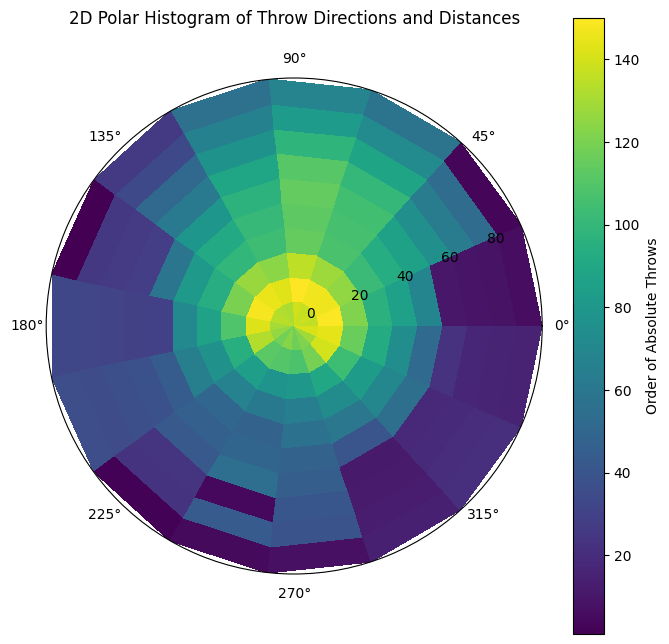

In [4]:
## Plot Radial Histogram of Distances
num_bins_angle = 15
num_bins_distance = 10
angle_bins = np.linspace(-np.pi, np.pi, num_bins_angle + 1)  # Bins for angles
distance_bins = np.linspace(0, df['throw_distance'].max(), num_bins_distance + 1)  # Bins for distances

# calculate bin values
hist, _, _ = np.histogram2d(df['throw_angle'], df['throw_distance'], bins=[angle_bins, distance_bins])
throw_order = np.argsort(hist, axis=None)
colors = np.zeros_like(hist.flatten())
for idx, order in enumerate(throw_order):
    colors[order] = idx + 1 
colors = colors.reshape(hist.shape)

# plot figure
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
theta, r = np.meshgrid(angle_bins[:-1], distance_bins[:-1]) 
c = ax.pcolormesh(theta, r, colors.T, cmap='viridis', shading='auto')
cbar = plt.colorbar(c, ax=ax)
cbar.set_label('Order of Absolute Throws')
ax.set_title('2D Polar Histogram of Throw Directions and Distances', pad=20)
plt.show()

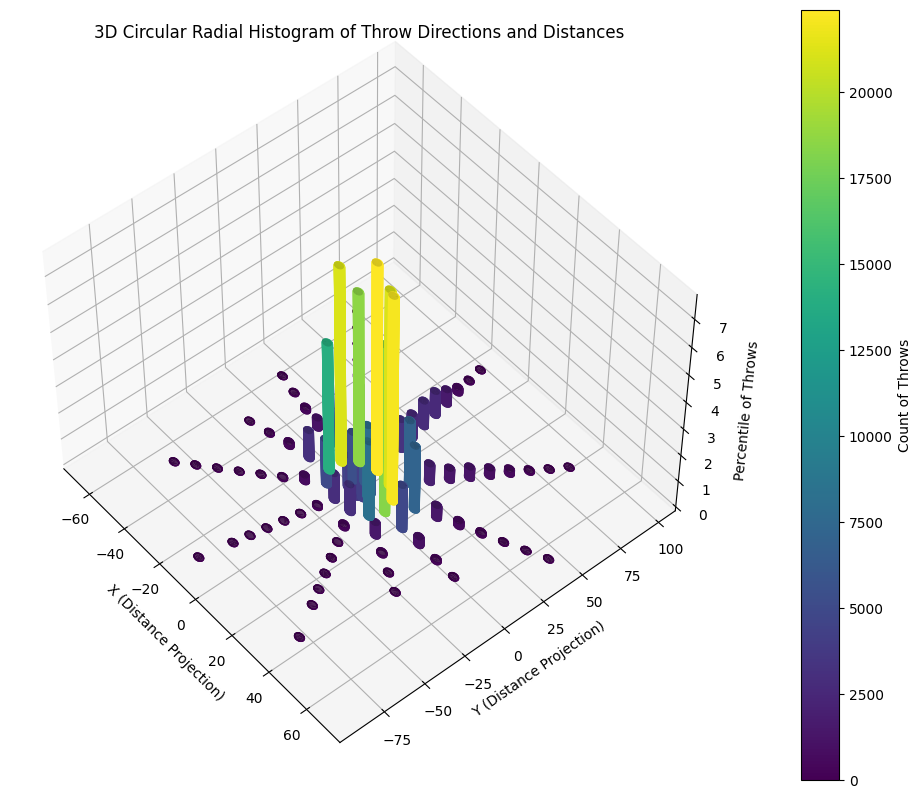

In [5]:
## 3D Radial Histogram of Distance and Direction

def draw_cylinder(ax, x_center, y_center, radius, height, color='b', alpha=1):
    num_points = 30
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = x_center + radius * np.cos(theta)
    y = y_center + radius * np.sin(theta)
    z = np.zeros(num_points)
    
    ax.plot_trisurf(x, y, z, color=color, alpha=alpha)

    for i in range(len(x) - 1):
        verts = [
            [(x[i], y[i], 0), (x[i + 1], y[i + 1], 0), 
             (x[i + 1], y[i + 1], height), (x[i], y[i], height)]
        ]
        ax.add_collection3d(Poly3DCollection(verts, color=color, alpha=alpha))
    
    z_top = np.ones(num_points) * height
    ax.plot_trisurf(x, y, z_top, color=color, alpha=alpha)


num_bins_angle = 11  # 10 bins for angles
num_bins_distance = 11  # 10 bins for distances
angle_bins = np.linspace(-np.pi, np.pi, num_bins_angle + 1)  # Bins for angles
distance_bins = np.linspace(0, df['throw_distance'].max(), num_bins_distance + 1)  # Bins for distances
hist, _, _ = np.histogram2d(df['throw_angle'], df['throw_distance'], bins=[angle_bins, distance_bins])
total_throws = np.sum(hist)
percentile_heights = (hist / total_throws) * 100  # Convert to percentage


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
theta = angle_bins[:-1] + (angle_bins[1] - angle_bins[0]) / 2  # Midpoints for angles
r = distance_bins[:-1] + (distance_bins[1] - distance_bins[0]) / 2  # Midpoints for distances
norm = plt.Normalize(vmin=0, vmax=np.max(hist))  # Normalization for color mapping
cmap = plt.cm.viridis  # Colormap
for i in range(num_bins_angle):
    for j in range(num_bins_distance):
        if hist[i, j] > 0:  # Only plot bars with counts
            # Calculate the center coordinates and height
            x_center = r[j] * np.cos(theta[i])
            y_center = r[j] * np.sin(theta[i])
            height = percentile_heights[i, j]  # Height of the cylinder corresponds to the percentile
            
            # Draw the cylinder with an increased radius
            color = cmap(norm(hist[i, j]))  # Get the color for the cylinder
            draw_cylinder(ax, x_center, y_center, radius=2, height=height, color=color, alpha=0.8)
ax.view_init(elev=50, azim=-40)  # Elevation and azimuth angles
ax.set_xlabel('X (Distance Projection)')
ax.set_ylabel('Y (Distance Projection)')
ax.set_zlabel('Percentile of Throws')
ax.set_title('3D Circular Radial Histogram of Throw Directions and Distances')

mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array([])  
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
cbar.set_label('Count of Throws')
plt.show()
